The aim of this notebook is to build a simple random forest regression model that makes predictions of peat depth using only Sentinel-2 imagery.

In later notebooks we hope to obtain models for the following experiments: 
1. A random forest regression model - model peat depth using the labelled dataset that we have. We will use only Sentinel 2 imagery as the predictor. 
2. Multi-predictor RF model - build the same model but this time add an additional second layer to the model e.g. lidar data
3. Linear regression model - see if we can build models that use linear regression to compare performance (generally we would expect RF to do better since its a non-linear model). 
4. Unsupervised model - we should use the inbuilt capabilities to build a basic presence/absence model using Sentinel 2 data only. In the future, to limit runtime, we may need a presence/absence model to limit the prediction area.
5. Completion - on completion of these four models, we should start looking at more advanced modelling methods such as AI/ML which will require exploration of the TensorFlow examples given. 


# Setup

In [1]:
# necessary imports 
import ee
import geemap
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

# if error with geopandas then try running:
# pip install --upgrade --force-reinstall shapely

/Users/hamishcampbell/opt/miniconda3/envs/geospatial/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# data and file paths
path_depths = "/Users/hamishcampbell/Documents/Cambridge/PhD/1st Year/Code/depth-mapping/Data/depth_samples.shp" 
path_fenOutline = "/Users/hamishcampbell/Documents/Cambridge/PhD/1st Year/Code/depth-mapping/Data/NCA_46_The_Fens.shp"

In [3]:
# initialise Google Earth Engine

# NOTE: first run only
#ee.Authenticate()

ee.Initialize()

# Data Loading

### Sentinel-2

In [4]:
# setup the base map for adding layers to
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [5]:
# load the Fens outline shape file into GEE
fenOutline = ee.FeatureCollection(geemap.shp_to_ee(path_fenOutline))

In [6]:
# get all surface reflectance Sentinel-2 imagery 
sen = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")

# keep only the data that meets some basic criteria
sen_filtered = (
    sen.filterBounds(fenOutline)                    # spatially limited to tiles overlapping Fens
    .filterDate('2022-01-01','2023-01-01')          # temporally limited to 2022 imagery
    .sort('CLOUD_COVERAGE_ASSESSMENT', False)       # sort tiles by cloud cover
    .select(['B[2-4]','MSK_CLDPRB']))               # only RGB and pixel probability of cloud presence  
    

In [7]:
# Write a function that alters the pixel validity mask of a tile according to if cloud is present or not
def check_cloud_absence(tile): 
    # if MSK_CLDPRB less than 10 => low chance of cloud => let mask remain valid at that pixel
    # if medium-high chance of cloud (>10) => update mask to say pixel is invalid (mask = 0)
    return tile.updateMask(tile.select('MSK_CLDPRB').lte(10))

In [8]:
# obtain a (mostly) cloud-free mosaic for each quarter 
quarterly_mosaics = []
filter_start = ee.Date('2022-01-01')

for quarter in range(0,4):
    
    # keep only tiles from the quarter being studied
    quarterly_sen = sen_filtered.filterDate(filter_start, filter_start.advance(3,'month'))
    
    # Update the pixel validity mask to include condition on cloud absence
    quarterly_sen = quarterly_sen.map(check_cloud_absence)
        
    # stitch the most cloud-free tiles together and replace remaining cloud pixels with those from next tile with presence
    # NOTE: by sorting on cloud presence we keep complete image as temporally contiguous as possible
    quarterly_mosaic = quarterly_sen.mosaic()
    
    # store the results required
    quarterly_mosaics.append(quarterly_mosaic.select(['B[2-4]']))
    
    # repeat for next quarter
    filter_start = filter_start.advance(3,'month')
    

In [9]:
# select the quarter of the year to use for modelling (1/2/3/4)
quarter = 2
sen_mosaic = quarterly_mosaics[quarter-1]

In [10]:
# Add the result to the map to check result
visParams = {
  'bands': ['B4', 'B3', 'B2'],
  'max': 3000,
  'min': 0,
}
Map.addLayer(sen_mosaic, visParams, 'Sentinel Mosaic')

### Fens Outline

In [11]:
# plot the outline in black with a transparent fill
style = {
    'color': 'red',
    'fillColor': '00000000'
}
Map.centerObject(fenOutline, 8)
Map.addLayer(fenOutline.style(**style), {}, 'Fen Outline')

### Depth Measurements

In [12]:
# load the depth measurements shape file into GEE
depths = geemap.shp_to_ee(path_depths)

# plot the points at which ground-truth measurements were taken on the map
style = {
    'color': 'blue',
    'pointSize': 2,
    'pointShape': 'circle'
}
Map.addLayer(depths.style(**style), {}, 'Depth Measurements')
Map

Map(center=[52.70465287691509, 0.062270855934294995], controls=(WidgetControl(options=['position', 'transparen…

# 1. Random Forest Regression

We need a feature collection containing Sentinel data for each of the training depth locations. This means we need to:
1. Sample the Sentinel-2 imagery at the ground-truth points
2. Inner join the GT data and Sentinel data using their geometries
3. Split the data into 90%-10% split
4. Feed this feature collection into the classifier model (regression mode)
5. Test the accuracy of the classifier 
6. Apply the classifier to the rest of the Fens boundary

### 1. Sampling

In [13]:
# sample the Sentinel data at each of the GT points
sen_samples = sen_mosaic.sample(depths.geometry(), scale=10, geometries=True) 

In [14]:
# To take random samples across the Fens
#sen_samples2 = sen_mosaic.sample(fenOutline.geometry(), 10, numPixels=171, geometries=True)

### 2. Inner Join (and buffering)

In [15]:
# define an algorithm to be applied to each Sentinel sample: we want to buffer the geometry of assigned to each sample
# by 10m, since the current geometry is approximate i.e. does not match the GT points used to guide sampler
def bufferPoints(currentFeature, pastFeatureList):
    return ee.List(pastFeatureList).add(currentFeature.buffer(10))

# apply the algorithm to each sample in our collection and store the result in a list
sen_samples = sen_samples.iterate(bufferPoints, ee.List([]))

# convert this list back into a FeatureCollection
sen_samples = ee.FeatureCollection(sen_samples.getInfo())

In [16]:
# Visualise the process completed
Map.addLayer(sen_samples, {}, 'Sentinel buffers')
Map

Map(center=[52.70465287691509, 0.062270855934294995], controls=(WidgetControl(options=['position', 'transparen…

In [17]:
# Setup the inner join operation between the Sentinel and GT datasets

# make a filter object that assesses intersections of objects. '.geo' specifies that for the 1st (left) and 2nd (right)
# objects being considered we want to apply the filter to the geometry fields of each feature instead of a property
intersectFilter = ee.Filter.intersects(leftField='.geo', rightField='.geo')

# define an inner join operation
IJ_operation = ee.Join.inner('sentinel_data', 'depth_data')

# apply the join
combinedDS = IJ_operation.apply(sen_samples, depths, intersectFilter)


In [18]:
# The result has a complex nested structure that isn't useful for the operations we want. Thus, re-define a new dataset
# with the same information but an improved structure 
def extract_depths(feature): 
    return feature.get('depth_data')

def extract_sentinel(feature): 
    return feature.get('sentinel_data')

# get information associated with the depth subcollection
depth_collection = combinedDS.map(extract_depths)

# get information associated with the sentinel subcollection
sentinel_collection = combinedDS.map(extract_sentinel)


In [19]:
# get the relevant information from the subcollections
geometries = depth_collection.geometry().getInfo()['coordinates']
thicknesses = depth_collection.aggregate_array('Thickness').getInfo()
B2 = sentinel_collection.aggregate_array('B2').getInfo()
B3 = sentinel_collection.aggregate_array('B3').getInfo()
B4 = sentinel_collection.aggregate_array('B4').getInfo()

In [20]:
# make a new feature collection that stores this information efficiently
data = []
idx = 0
for coords in geometries:
    feature = ee.Feature(ee.Geometry.Point(coords), 
                         {'depth': thicknesses[idx], 
                          'B2': B2[idx],
                          'B3': B3[idx],
                          'B4': B4[idx]})
    data.append(feature)
    idx += 1
    
# finally convert the data into a feature collection    
dataset = ee.FeatureCollection(data)

### 3. Train/test split

In [21]:
# add a column of uniformly distributed numbers between 0 and 1
withRandom = dataset.randomColumn('random')

# split the dataset according to this random column (< or >= train_prop)
train_prop = 0.9
trainingSet = withRandom.filter(ee.Filter.lt('random', train_prop))
testingSet = withRandom.filter(ee.Filter.gte('random', train_prop))

In [22]:
# remove irrelevant properties 
trainingSet = trainingSet.select(['B[2-4]', 'depth'])
testingSet = testingSet.select(['B[2-4]', 'depth'])

In [23]:
# Visualise the two datasets 
Map = geemap.Map()

# Re-plot Sentinel-2 imagery
visParams = {
  'bands': ['B4', 'B3', 'B2'],
  'max': 3000,
  'min': 0,
}
Map.addLayer(sen_mosaic, visParams, 'Sentinel Mosaic')

# Re-plot the Fens outline
style = {
    'color': 'red',
    'fillColor': '00000000'
}
Map.centerObject(fenOutline, 8)
Map.addLayer(fenOutline.style(**style), {}, 'Fen Outline')

# Plot the training dataset in blue
style = {
    'color': 'blue',
    'pointSize': 2,
    'pointShape': 'circle'
}
Map.addLayer(trainingSet.style(**style), {}, 'Training Data')

# plot the testing dataset in purple
style = {
    'color': 'purple',
    'pointSize': 2,
    'pointShape': 'circle'
}
Map.addLayer(testingSet.style(**style), {}, 'Testing Data')
Map


Map(center=[52.70465287691509, 0.062270855934294995], controls=(WidgetControl(options=['position', 'transparen…

### 4. Train a classifier 

"Training" a classifier in GEE involves setting it up, but it only actually gets trained once we make a prediction using the classifier. Typically the classifiers in GEE are used for categorical variable predictions rather than continuos variable prediction

In [24]:
# specify the type of classifier, hyperparameters and output mode of the model
classifier_RF = ee.Classifier.smileRandomForest(10).setOutputMode('REGRESSION')

In [25]:
# train the model using the label/feature data specified
trainedClassifier = classifier_RF.train(features = trainingSet, 
                                        classProperty = 'depth', 
                                        inputProperties = ['B2', 'B3', 'B4'])


In [26]:
# provide some basic insights into the trained model (this can be optionally plotted later)
trainedClassifier.explain().getInfo()

{'importance': {'B2': 7475982.838756263,
  'B3': 4773463.014824969,
  'B4': 6622450.315366683},
 'numberOfTrees': 10,
 'outOfBagErrorEstimate': 89.00757447802272}

In [27]:
# use the trained model to make predictions for training and test points
trainPredictions = trainingSet.classify(trainedClassifier, 'predicted depth')
testPredictions = testingSet.classify(trainedClassifier, 'predicted depth')

### 5. Assess model accuracy

Plot a histogram of training GT depths and a histogram of corresponding predictions

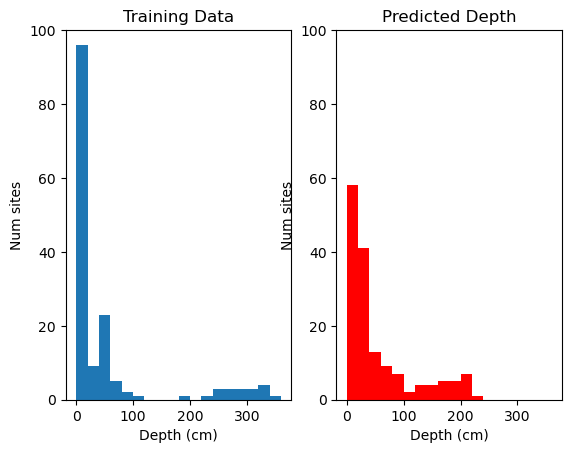

In [28]:
# get the relevant data
actual_depths = trainPredictions.aggregate_array('depth').getInfo()
predicted_depths = trainPredictions.aggregate_array('predicted depth').getInfo()

# plot the GT histogram
plt.subplot(1,2,1)
plt.hist(actual_depths, bins=18, range=(0,360));
plt.xlabel("Depth (cm)")
plt.ylabel("Num sites")
plt.title("Training Data");
ax = plt.gca()
ax.set_ylim([0, 100]);

# plot the prediction histogram
plt.subplot(1,2,2)
plt.hist(predicted_depths, bins=18, range=(0,360), color='red');
plt.xlabel("Depth (cm)")
plt.ylabel("Num sites")
plt.title("Predicted Depth");
ax = plt.gca()
ax.set_ylim([0, 100]);

Plot a scatter plot of the labels vs the predictions for the training data. If the accurate was 100% accurate then we would expect all the data points to line of the y=x curve

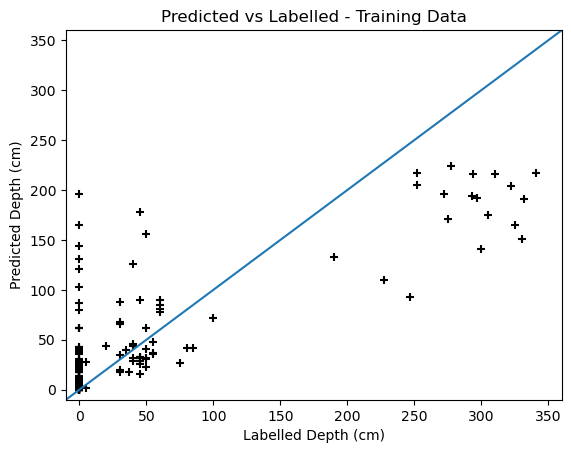

In [29]:
# add a scatter plot of the data points
plt.scatter(actual_depths, predicted_depths, c='black', marker='+');
plt.xlabel("Labelled Depth (cm)")
plt.ylabel("Predicted Depth (cm)")
plt.title("Predicted vs Labelled - Training Data");
ax = plt.gca()
ax.set_ylim([-10, 360]);
ax.set_xlim([-10, 360]);

# add a y=x line
plt.plot([-10, 360], [-10, 360]);

In [30]:
# calculate the R-Squared and RMSE error to model evaluation
R_squared = r2_score(actual_depths, predicted_depths)
print("R Squared:", R_squared)

RMSE = mean_squared_error(actual_depths, predicted_depths, squared=False)
print("RMSE:", RMSE)

R Squared: 0.6380706801150894
RMSE: 58.09072263816255


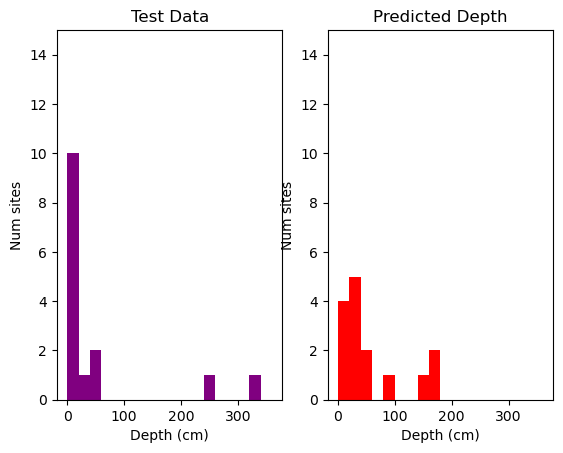

In [31]:
# get the relevant data
actual_depths = testPredictions.aggregate_array('depth').getInfo()
predicted_depths = testPredictions.aggregate_array('predicted depth').getInfo()

# plot the GT histogram
plt.subplot(1,2,1)
plt.hist(actual_depths, bins=18, range=(0,360), color='purple');
plt.xlabel("Depth (cm)")
plt.ylabel("Num sites")
plt.title("Test Data");
ax = plt.gca()
ax.set_ylim([0, 15]);

# plot the prediction histogram
plt.subplot(1,2,2)
plt.hist(predicted_depths, bins=18, range=(0,360), color='red');
plt.xlabel("Depth (cm)")
plt.ylabel("Num sites")
plt.title("Predicted Depth");
ax = plt.gca()
ax.set_ylim([0, 15]);

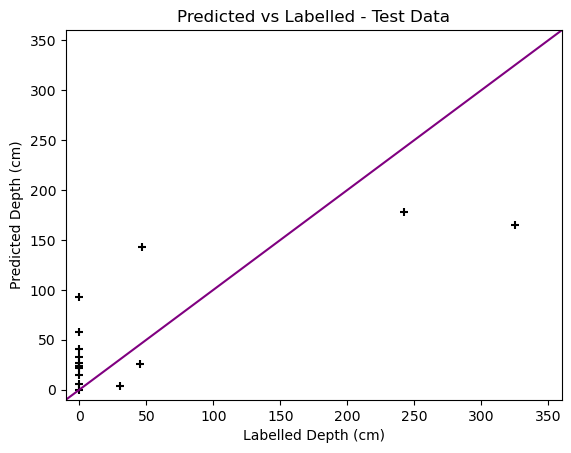

In [32]:
# add a scatter plot of the data points
plt.scatter(actual_depths, predicted_depths, c='black', marker='+');
plt.xlabel("Labelled Depth (cm)")
plt.ylabel("Predicted Depth (cm)")
plt.title("Predicted vs Labelled - Test Data");
ax = plt.gca()
ax.set_ylim([-10, 360]);
ax.set_xlim([-10, 360]);

# add a y=x line
plt.plot([-10, 360], [-10, 360], c='purple');

In [33]:
# calculate the R-Squared and RMSE error to model evaluation
R_squared = r2_score(actual_depths, predicted_depths)
print("R Squared:", R_squared)

RMSE = mean_squared_error(actual_depths, predicted_depths, squared=False)
print("RMSE:", RMSE)

R Squared: 0.588314293314429
RMSE: 61.470210792015465


### 6. Predict across Fens

In [34]:
# clip the sentinel imagery to only that within the Fens boundary 
clipped_sen = sen_mosaic.clip(fenOutline)

In [35]:
# make predictions across the Fens using the Sentinel imagery
classified_sen = clipped_sen.classify(trainedClassifier, 'prediction')

In [36]:
# find the minimum prediction value
predictedMin = classified_sen.reduceRegion(reducer=ee.Reducer.min(), geometry=fenOutline, scale=10, bestEffort=True)
minVal = predictedMin.getNumber('prediction').getInfo()
print("Minimum:", minVal)

# find the maximum prediction value
predictedMax = classified_sen.reduceRegion(reducer=ee.Reducer.max(), geometry=fenOutline, scale=10, bestEffort=True)
maxVal = predictedMax.getNumber('prediction').getInfo()
print("Maximum", maxVal)

Minimum: 0
Maximum 254.8


In [39]:
# plot the predictions: black = 0cm, red = 285cm
Map = geemap.Map()
visParams = {
    'palette': ['030303', 'd11515'],
    'max': maxVal,
    'min': minVal,
}
Map.centerObject(fenOutline, 8)
Map.addLayer(classified_sen, visParams, 'Peat depth predictions')
Map

Map(center=[52.70465287691509, 0.062270855934294995], controls=(WidgetControl(options=['position', 'transparen…